# ssd_layers.py #
**
get_output_shape_for(self, input_shape)  
→  
compute_output_shape(self, input_shape)  
**  
なぜこう変更すれば改善するのかは謎

# run.py #
**
model = SSD300(input_shape, num_classes=NUM_CLASSES)  
model.load_weights('weights_SSD300.hdf5', by_name=True)  
→  
model = SSD300(input_shape, num_classes=NUM_CLASSES)  
model.load_weights('weights_SSD300.hdf5', by_name=True)  
model.compile('sgd','mse')  
**  
keras2.0による変更

**  
img_path = './pics/名前.jpg'  
img = image.load_img(img_path, target_size=(300, 300))  
img = image.img_to_array(img)  
images.append(imread(img_path))  
inputs.append(img.copy())  
**  
  
  の追加で複数枚OK

In [1]:
%matplotlib inline

C:\Users\Yasunari Ota\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Yasunari Ota\desktop\ssd_on_keras\ssd.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1", padding="same")`
  name='conv1_1')(net['input'])
C:\Users\Yasunari Ota\desktop\ssd_on_keras\ssd.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same")`
  name='conv1_2')(net['conv1_1'])
C:\Users\Yasunari Ota\desktop\ssd_on_keras\ssd.py:46: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), strides=(2, 2), name="pool1", padding="same")`
  name='pool1')(net['conv1_2'])
C:\

Instructions for updating:
dim is deprecated, use axis instead


C:\Users\Yasunari Ota\desktop\ssd_on_keras\ssd.py:140: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), name="conv4_3_norm_mbox_loc", padding="same")`
  name='conv4_3_norm_mbox_loc')(net['conv4_3_norm'])
C:\Users\Yasunari Ota\desktop\ssd_on_keras\ssd.py:148: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(63, (3, 3), name="conv4_3_norm_mbox_conf", padding="same")`
  name=name)(net['conv4_3_norm'])
C:\Users\Yasunari Ota\desktop\ssd_on_keras\ssd.py:160: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), name="fc7_mbox_loc", padding="same")`
  name='fc7_mbox_loc')(net['fc7'])
C:\Users\Yasunari Ota\desktop\ssd_on_keras\ssd.py:168: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(126, (3, 3), name="fc7_mbox_conf", padding="same")`
  name=name)(net['fc7'])
C:\Users\Yasunari Ota\desktop\ssd_on_keras\ssd.py:178: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), name="conv

1/1 [==============================] - 2s 2s/step


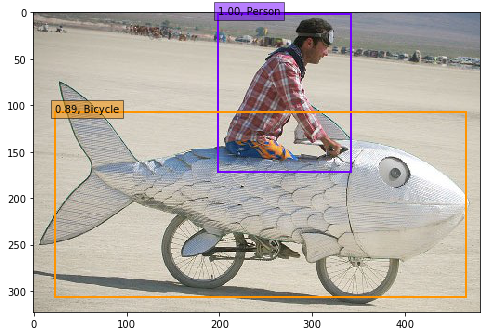

In [2]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf

from ssd import SSD300
from ssd_utils import BBoxUtility

# matplotlib表示画像の拡大　大した意味なし
plt.rcParams['figure.figsize'] = (8, 8)
# 画像を見やすいようにするかみたいな　ここではしない設定
plt.rcParams['image.interpolation'] = 'nearest'

# npの行列の指数表示の禁止　大した意味なし
np.set_printoptions(suppress=True)

# tensorflowの設定クラス
config = tf.ConfigProto()
# GPUのメモリの何％を使うか否か　あまり関係ない
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1
# (300, 300)では自動的に画像を(300, 300)に拡大・縮小している
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)
model.compile('sgd','mse')
bbox_util = BBoxUtility(NUM_CLASSES)

inputs = []
images = []
img_path = './pics/fish-bike.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
# preprocess_input()は平均値を引いてRGB→BGRにしているだけ
# 0-1にしているわけではないから注意
inputs = preprocess_input(np.array(inputs))

# verbose=1はログを出す設定
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    # おそらく予測確率
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    # 矩形の座標軸(?)
    currentAxis = plt.gca()


    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

    plt.show()
